In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import folium

import json
from loguru import logger
from pathlib import Path

from geowrangler.datasets import geofabrik

import sys

sys.path.append("../../../")  # include parent directory
from src.vector_utils import *

# Assess OSM for relevant classes

This notebook's purpose is to assess the available datasets and classes we can get from OpenStreetMap for the year 2022. The main objectives are to:
- Assess completeness across the target cities;
- Establish the necessary functions for incoming data for the following years; and
- Determine whether other datasets are needed to be used

### Input

- Administrative boundaries
- OSM POIs dataset
- OSM Water and Waterways
- Generated Coastal Buffer
- Geoportal Health Facilities *(came after spot-checking OSM Health POIs)*

### Output

**Features output**

- POI counts
- Nearest distances to POI classes 
- Nearest distances to bodies of water (water and waterways)
- Nearest distance to coast

**Notebook output**

- Temporary Master table of extracted features
- Folium maps


### Set-up Input Parameters

In [5]:
# data directories
DATA_DIR = Path("../../../data/")
SRC_DIR = Path("../../../src/")
ADMIN_FPATH = DATA_DIR / "01-admin-bounds"
RAW_FPATH = DATA_DIR / "02-raw"
PROCESSED_FPATH = DATA_DIR / "03-processed"
OUTPUT_FPATH = DATA_DIR / "04-output"
GIS_FPATH = DATA_DIR / "05-gis"

In [6]:
# Parameters

# POI types of OSM
# tags taken from https://wiki.openstreetmap.org/wiki/Map_features
poi_file = Path(SRC_DIR / "osm_poi_categories.json")

with open(poi_file, "r") as f:
    data = json.load(f)

POI_TYPES_NEEDED = []
for category in data:
    POI_TYPES_NEEDED += data[category]

# change this parameter to download for other years
OSM_YEAR = "2022"
OSM_COUNTRY = "philippines"

In [7]:
# how many needed types
len(POI_TYPES_NEEDED)

58

### Load AOIs and Generated SHP files

In [8]:
# Load the administrative boundaries for the 12 cities
admin_bounds_gdf = gpd.read_file(ADMIN_FPATH / "renamed_target_admin_bounds.shp")
admin_bounds_gdf.head(2)

,region_nam,region_cod,province_n,province_c,city_name,city_code,barangay_n,barangay_p,geometry
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053..."
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039..."


In [9]:
# Load generated osm poi features for 2022
osm_poi_feats_gdf = gpd.read_file(PROCESSED_FPATH / "osm_poi_features.gpkg")

## 1. Check OSM availability using Metro Manila

Metro Manila will be used to assess completeness of POI types for the whole PH. The available needed POI types that are present in Metro Manila were filtered in QGIS beforehand.

In [10]:
ncr_test = gpd.read_file(DATA_DIR / "03-processed" / "metro_manila_osm_pois.geojson")
ncr_test.head()

,osm_id,code,fclass,name,field_1,ADM1_EN,geometry
0,21717820,2907,camera_surveillance,None,False,National Capital Region,POINT (121.02120 14.57608)
1,21717872,2722,museum,Ayala Museum,False,National Capital Region,POINT (121.02324 14.55358)
2,24078301,2402,motel,Sogo Grand Hotel,False,National Capital Region,POINT (121.04515 14.56449)
3,24078959,2907,camera_surveillance,None,False,National Capital Region,POINT (121.05945 14.60098)
4,24797511,2542,bicycle_shop,Christine Sports Cycle Marketing,False,National Capital Region,POINT (120.99506 14.55224)


In [11]:
ncr_poi_summary = pd.read_csv(
    DATA_DIR / "03-processed" / "osm_pois_filtered_avilability.csv"
)
ncr_poi_summary.sort_values(by="count", ascending=False)

,fclass,count
4,bank,2452
13,convenience,1899
7,pharmacy,971
28,recycling,751
1,school,570
11,atm,474
5,supermarket,420
23,dentist,272
21,toilet,269
15,police,210


Check what POI types are missing in Metro Manila.

In [12]:
available_poi_types = ncr_test["fclass"].unique().tolist()
lacking = list(set(POI_TYPES_NEEDED) - set(available_poi_types))
lacking

['water_mill',
 'connection',
 'exchange',
 'generator',
 'converter',
 'minor_line',
 'bay',
 'portal',
 'connection_point',
 'pole',
 'sanitary_dump_station',
 'service_device',
 'line',
 'busbar',
 'data_center',
 'cable',
 'plant',
 'compensator',
 'waste_transfer_station',
 'substation',
 'distribution_point',
 'insulator',
 'transformer',
 'clinic']

## 2. Map POIs in Target Areas

- per city and per barangay visualization
- points (color coded based on category)
- visualize the counts per category for sample cities

In [13]:
osm_poi_feats_gdf = osm_poi_feats_gdf.set_geometry("geometry")

Visualize through a chloropleth the total POI counts for each target barangay.

In [14]:
# map of poi counts
GOOGLE_BASEMAP = folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Satellite",
    overlay=True,
    control=True,
    show=True,
)

poi_count_map = osm_poi_feats_gdf.explore(
    column="poi_count",
    cmap="Wistia",
    tooltip=["region_name", "province_name", "city_name", "barangay_name", "poi_count"],
)

GOOGLE_BASEMAP.add_to(poi_count_map)

# UNCOMMENT TO DISPLAY MAP
# poi_count_map

In [26]:
# UNCOMMENT TO SAVE FOLIUM MAP
# poi_count_map.save(GIS_FPATH / "osm_poi_count_map.html")

Based on the map above, there is a number of barangays that have 0 of the POIs we are looking for.

Investigate the barangays/cities  that have none of the target POIs.

In [15]:
osm = geofabrik.OsmDataManager(cache_dir="../../../data/02-raw/")
osm_pois_2022 = osm.load_pois(region=OSM_COUNTRY, year=OSM_YEAR, use_cache=True)

2023-06-05 21:16:20.186 | INFO     | geowrangler.datasets.geofabrik:download_osm_region_data:128 - OSM Data: Cached data available for philippines at ../../../data/02-raw/osm/philippines-220101-free.shp.zip? True
2023-06-05 21:16:20.187 | DEBUG    | geowrangler.datasets.geofabrik:load_pois:222 - OSM POIs for philippines and year 2022 being loaded from ../../../data/02-raw/osm/philippines-220101-free.shp.zip


In [16]:
joined_target_poi_all = gpd.sjoin(osm_pois_2022, admin_bounds_gdf)
joined_target_poi_all = joined_target_poi_all[
    joined_target_poi_all["fclass"].isin(POI_TYPES_NEEDED)
]

In [17]:
# do another folium map of all pois in the target areas

GOOGLE_BASEMAP = folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Satellite",
    overlay=True,
    control=True,
    show=True,
)

pois_all = joined_target_poi_all.explore(column="fclass")

GOOGLE_BASEMAP.add_to(pois_all)
#
#  pois_all

### 2.1 POI types distributions

Check which POI types are the highest in some of the target cities that have high and low POI counts.

In [18]:
filtered_join = joined_target_poi_all[
    joined_target_poi_all["fclass"].isin(POI_TYPES_NEEDED)
]

davao_city = filtered_join[filtered_join["city_name"] == "Davao City"]
munti_city = filtered_join[filtered_join["city_name"] == "City of Muntinlupa"]
palayan_city = filtered_join[filtered_join["city_name"] == "Palayan City"]
navotas_city = filtered_join[filtered_join["city_name"] == "City of Navotas"]

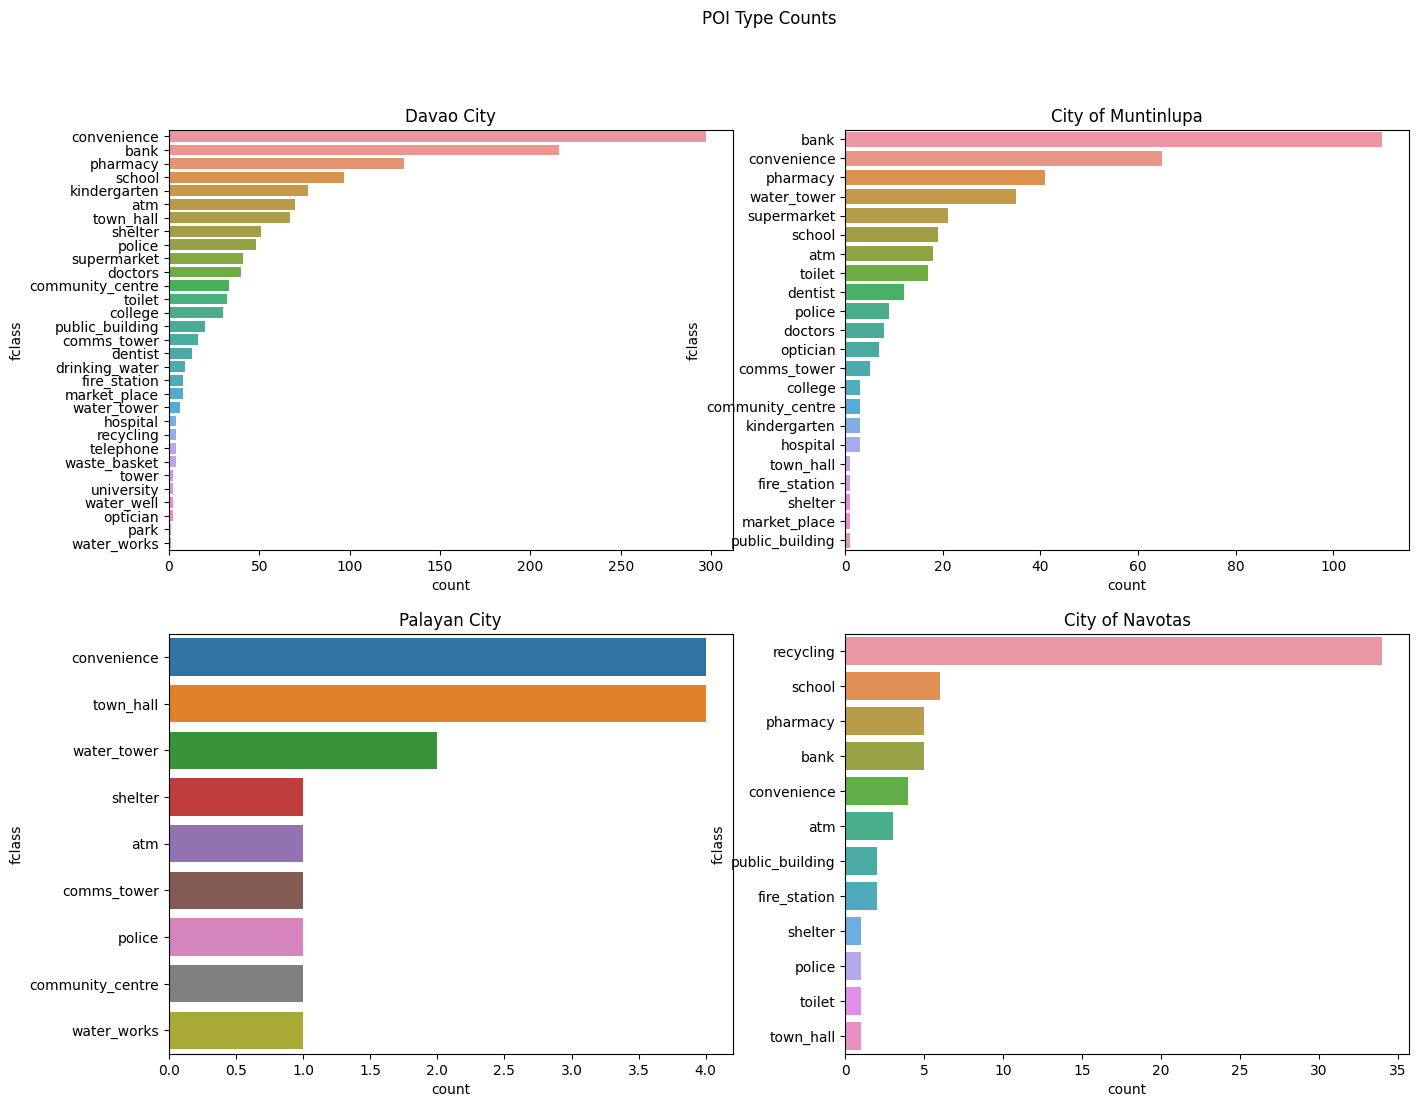

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("POI Type Counts")

city_to_viz = [davao_city, munti_city, palayan_city, navotas_city]

for city, ax in zip(city_to_viz, axs.flat):
    plt.figure()
    sns.countplot(
        ax=ax,
        data=city,
        y="fclass",
        order=city["fclass"].value_counts().index,
    )
    ax.set_title(city["city_name"].iloc[0])
plt.show()

## 3. Study each POI category

In [27]:
# create categories
health_pois = data["health"]
crit_lifelines = data["crit_lifelines"]
power_pois = data["power"]
telco_pois = data["telco"]
water_pois = data["water"]
sanitation_pois = data["sanitation"]

# get the feature cols in the OSM POI features table
def get_poi_category_cols(poi_name_list, df=osm_poi_feats_gdf):
    poi_cols = [x for x in df.columns[df.columns.str.contains("|".join(poi_name_list))]]
    return poi_cols


health_cols = get_poi_category_cols(health_pois)
crit_cols = get_poi_category_cols(crit_lifelines)
power_cols = get_poi_category_cols(power_pois)
telco_cols = get_poi_category_cols(telco_pois)
water_cols = get_poi_category_cols(water_pois)
sanitation_cols = get_poi_category_cols(sanitation_pois)

admin_cols = ["region_name", "province_name", "city_name", "barangay_name", "geometry"]

### 3.1 Spot-check health

Compare OSM Health tags availability to DOH's Geoportal.

In [28]:
health_availability = osm_poi_feats_gdf[admin_cols + health_cols]

In [29]:
(health_availability == 0).all()

ADM1_EN             False
ADM2_EN             False
ADM3_EN             False
ADM4_EN             False
geometry            False
clinic_count         True
clinic_nearest      False
dentist_count       False
dentist_nearest     False
doctors_count       False
doctors_nearest     False
hospital_count      False
hospital_nearest    False
optician_count      False
optician_nearest    False
pharmacy_count      False
pharmacy_nearest    False
dtype: bool

In [34]:
health_availability = health_availability.drop(
    columns=["clinic_count", "clinic_nearest"]
)
health_availability

,ADM1_EN,ADM2_EN,ADM3_EN,ADM4_EN,geometry,dentist_count,dentist_nearest,doctors_count,doctors_nearest,hospital_count,hospital_nearest,optician_count,optician_nearest,pharmacy_count,pharmacy_nearest
137,National Capital Region,"NCR, Fourth District",City of Muntinlupa,Alabang,"POLYGON ((121.05364 14.42508, 121.05394 14.424...",3.0,0.000000,5.0,0.000000,1.0,0.000000,4.0,0.000000,16.0,0.000000
265,National Capital Region,"NCR, Second District",City of Mandaluyong,Highway Hills,"POLYGON ((121.05614 14.57903, 121.05712 14.578...",3.0,0.000000,1.0,0.000000,0.0,2768.414322,0.0,693.992914,5.0,0.000000
441,National Capital Region,"NCR, Fourth District",City of Muntinlupa,New Alabang Village,"POLYGON ((121.03128 14.42464, 121.03163 14.424...",0.0,457.618159,1.0,0.000000,0.0,1529.619915,0.0,208.061678,4.0,0.000000
709,Region XI,Davao del Sur,Davao City,Bucana,"POLYGON ((125.60493 7.06428, 125.60548 7.06383...",1.0,0.000000,0.0,146.171320,0.0,779.981957,0.0,1175.457721,7.0,0.000000
127,National Capital Region,"NCR, Second District",City of Mandaluyong,Wack-wack Greenhills,"POLYGON ((121.05959 14.60027, 121.05965 14.599...",1.0,0.000000,1.0,0.000000,0.0,1057.778822,0.0,651.111363,7.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Region VI,Iloilo,Iloilo City,Mansaya-Lapuz,"POLYGON ((122.58780 10.70184, 122.58786 10.701...",0.0,4950.343485,0.0,1700.742365,0.0,2929.863627,0.0,1342.705887,0.0,593.014356
476,Region VI,Iloilo,Iloilo City,Hinactacan,"POLYGON ((122.58621 10.74522, 122.58865 10.743...",0.0,4528.801785,0.0,3405.495004,0.0,2675.052396,0.0,3979.484402,0.0,1937.599192
466,Region VI,Iloilo,Iloilo City,Jalandoni-Wilson,"POLYGON ((122.56115 10.69578, 122.56163 10.695...",0.0,3165.714588,0.0,130.617977,0.0,2044.838637,0.0,659.187189,0.0,49.782448
461,Region V,Albay,Legazpi City,Bgy. 67 - Bariis (Bgy. 46),"POLYGON ((123.75267 13.03616, 123.77560 13.028...",0.0,10000.000000,0.0,10000.000000,0.0,3922.009052,0.0,10000.000000,0.0,10000.000000


In [35]:
health_availability.describe()

,dentist_count,dentist_nearest,doctors_count,doctors_nearest,hospital_count,hospital_nearest,optician_count,optician_nearest,pharmacy_count,pharmacy_nearest
count,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000
mean,0.088737,3283.455385,0.094425,2560.039378,0.020478,3603.145624,0.026166,4710.299283,0.588168,1882.071930
std,0.392235,3545.202909,0.380568,3403.746020,0.149530,3398.815020,0.239585,4046.257264,1.532085,3230.325524
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,428.241133,0.000000,337.104023,0.000000,1140.483393,0.000000,950.776510,0.000000,7.657771
50%,0.000000,1828.051686,0.000000,956.731964,0.000000,2153.014636,0.000000,3045.584421,0.000000,262.932890
75%,0.000000,4913.836601,0.000000,3040.874086,0.000000,4933.610537,0.000000,10000.000000,0.000000,1720.985551
max,4.000000,10000.000000,5.000000,10000.000000,2.000000,10000.000000,4.000000,10000.000000,16.000000,10000.000000


Total count of the health classes. Surprisingly, hospital count is just 18 which is unrealistic for 12 cities.

In [36]:
count_cols = get_count_cols(health_availability)
health_availability[count_cols].sum()

dentist_count      78.0
doctors_count      83.0
hospital_count     18.0
optician_count     23.0
pharmacy_count    517.0
dtype: float64

In [37]:
health_availability[admin_cols + count_cols].groupby("city_name").sum()

/tmp/ipykernel_23097/3144665298.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  health_availability[admin_cols + count_cols].groupby("ADM3_EN").sum()


,dentist_count,doctors_count,hospital_count,optician_count,pharmacy_count
ADM3_EN,,,,,
Cagayan de Oro City,10.0,3.0,3.0,0.0,54.0
City of Mandaluyong,15.0,5.0,0.0,1.0,41.0
City of Muntinlupa,12.0,8.0,3.0,7.0,41.0
City of Navotas,0.0,0.0,0.0,0.0,5.0
Dagupan City,12.0,4.0,1.0,5.0,49.0
Davao City,13.0,40.0,4.0,2.0,130.0
Iloilo City,2.0,8.0,3.0,3.0,71.0
Legazpi City,5.0,2.0,0.0,2.0,14.0
Mandaue City,1.0,6.0,1.0,0.0,36.0


Now compare it with the **Hospitals and health facilities from Geoportal**.

In [38]:
doh_health = gpd.read_file(
    RAW_FPATH / "philippines_healthfacilities.gpkg", driver="GPKG"
)
doh_health.head()

,id,facilityco,healthfaci,typeofheal,barangay,municipali,province,region,status,address,style,geometry
0,1.0,DOH000000000002277,Calvario Barangay Health Station,Barangay Health Station,Calvario,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (121.98987 6.65182)
1,2.0,DOH000000000010319,Cabunbata Barangay Health Station,Barangay Health Station,Cabunbata,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (121.96630 6.67152)
2,3.0,DOH000000000001601,Begang Barangay Health Station,Barangay Health Station,Begang,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (122.01392 6.68954)
3,4.0,DOH000000000010340,Busay Barangay Health Station,Barangay Health Station,Busay,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (122.00549 6.69013)
4,5.0,DOH000000000010310,Sumagdang Barangay Health Station,Barangay Health Station,Sumagdang,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (121.95776 6.69125)


In [39]:
doh_health.shape

(23676, 12)

In [40]:
# filter to target cities
target_cities = [
    "Navotas",
    "Mandaluyong",
    "Muntinlupa",
    "Dagupan City",
    "Palayan City",
    "Legazpi City",
    "Iloilo City",
    "Mandaue City",
    "Tacloban City",
    "Zamboanga City",
    "Cagayan de Oro City",
    "Davao City",
]
filtered_doh = doh_health[
    doh_health["municipali"].str.contains("|".join(target_cities), case=False)
]

In [41]:
# check if it contains the target cities
filtered_doh["municipali"].unique()

array(['Zamboanga City', 'Cagayan De Oro City (Capital)', 'MANDAUE CITY',
       'ILOILO CITY (CAPITAL)', 'ILOILO CITY (CAPITAL)*', 'DAGUPAN CITY',
       'MANDALUYONG', 'NAVOTAS', 'MUNTINLUPA CITY', 'PALAYAN CITY',
       'DAVAO CITY', 'TACLOBAN CITY (CAPITAL)', 'LEGAZPI CITY (CAPITAL)'],
      dtype=object)

In [42]:
# already way more than the OSM
filtered_doh.shape

(727, 12)

Below are the types of health facilities available from geoportal. Classes are much clearer compared to OSM POIs. The only good thing from OSM POIs are the presence of pharmacies which do not seem to be included here in the Geoportal. 

In [43]:
filtered_doh["typeofheal"].value_counts()

Barangay Health Station                           417
Rural Health Unit                                 119
Hospital                                          110
Birthing Home/Lying-in Clinic                      68
Medical Clinic                                      5
Infirmary                                           4
Social Hygiene Clinic                               3
Drug Abuse Treatment and Rehabilitation Center      1
Name: typeofheal, dtype: int64

In [44]:
filtered_doh["status"].value_counts()

Functional                                 421
Active                                      59
Functional/additional                        6
Additional                                   6
New Health Facility                          4
Not On Doh List, Functional                  3
Not Functional                               1
Newly Constructed                            1
Same As 32-d Rural Health Unit               1
New Health Facility, Under Construction      1
New BHS, Functional                          1
New                                          1
Name: status, dtype: int64

Create stats for DOH health facilities

In [45]:
doh_health_feat = add_point_features(admin_bounds_gdf, filtered_doh, "typeofheal")
doh_health_feat.head()

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,poi_count,...,Birthing Home/Lying-in Clinic_count,Birthing Home/Lying-in Clinic_nearest,Infirmary_count,Infirmary_nearest,Drug Abuse Treatment and Rehabilitation Center_count,Drug Abuse Treatment and Rehabilitation Center_nearest,Social Hygiene Clinic_count,Social Hygiene Clinic_nearest,Medical Clinic_count,Medical Clinic_nearest
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053...",0.0,...,0.0,1374.683230,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039...",3.0,...,0.0,360.111127,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
2,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Pantal,PH015518022,"POLYGON ((120.34737 16.06009, 120.34761 16.060...",4.0,...,1.0,0.000000,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
3,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Barangay I (T. Bugallon),PH015518024,"POLYGON ((120.34054 16.04489, 120.34054 16.044...",0.0,...,0.0,1234.886976,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
4,Region III,PH030000000,Nueva Ecija,PH034900000,Palayan City,PH034919000,Imelda Valley,PH034919017,"POLYGON ((121.12250 15.58028, 121.12687 15.579...",0.0,...,0.0,10000.000000,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0


In [46]:
doh_health_feat_df = doh_health_feat.drop(columns=["geometry"])
doh_health_feat_df = pd.DataFrame(doh_health_feat_df)
doh_health_feat_df.to_csv(OUTPUT_FPATH / "doh_health_geoportal.csv")

In [46]:
count_cols = get_count_cols(doh_health_feat)
doh_health_feat[count_cols].sum()

poi_count                                               727.0
Barangay Health Station_count                           417.0
Rural Health Unit_count                                 119.0
Hospital_count                                          110.0
Birthing Home/Lying-in Clinic_count                      68.0
Infirmary_count                                           4.0
Drug Abuse Treatment and Rehabilitation Center_count      1.0
Social Hygiene Clinic_count                               3.0
Medical Clinic_count                                      5.0
dtype: float64

In [47]:
doh_health_feat[admin_cols + count_cols].groupby("ADM3_EN").sum()

/tmp/ipykernel_22402/756161520.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  doh_health_feat[admin_cols + count_cols].groupby("ADM3_EN").sum()


,poi_count,Barangay Health Station_count,Rural Health Unit_count,Hospital_count,Birthing Home/Lying-in Clinic_count,Infirmary_count,Drug Abuse Treatment and Rehabilitation Center_count,Social Hygiene Clinic_count,Medical Clinic_count
ADM3_EN,,,,,,,,,
Cagayan de Oro City,94.0,36.0,28.0,12.0,15.0,2.0,1.0,0.0,0.0
City of Mandaluyong,43.0,5.0,26.0,11.0,0.0,0.0,0.0,0.0,1.0
City of Muntinlupa,38.0,2.0,15.0,11.0,9.0,0.0,0.0,1.0,0.0
City of Navotas,21.0,1.0,11.0,1.0,8.0,0.0,0.0,0.0,0.0
Dagupan City,30.0,15.0,1.0,11.0,3.0,0.0,0.0,0.0,0.0
Davao City,183.0,140.0,13.0,27.0,0.0,0.0,0.0,0.0,3.0
Iloilo City,101.0,73.0,6.0,11.0,10.0,0.0,0.0,1.0,0.0
Legazpi City,19.0,16.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
Mandaue City,40.0,26.0,1.0,7.0,5.0,0.0,0.0,1.0,0.0


### 3.2 Spot-check Sanitation

In [48]:
sanitation_availability = osm_poi_feats_gdf[admin_cols + sanitation_cols]

In [49]:
sanitation_availability.describe()

,sanitary_dump_station_count,sanitary_dump_station_nearest,toilet_count,toilet_nearest,recycling_count,recycling_nearest,waste_basket_count,waste_basket_nearest,wastewater_plant_count,wastewater_plant_nearest,waste_transfer_station_count,waste_transfer_station_nearest
count,879.0,879.0,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.0,879.0
mean,0.0,10000.0,0.102389,2769.708799,0.052332,7690.752965,0.004551,9109.889734,0.001138,9537.972302,0.0,10000.0
std,0.0,0.0,0.587246,3165.352459,0.404407,3550.716449,0.082541,2337.477364,0.033729,1660.305762,0.0,0.0
min,0.0,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10000.0
25%,0.0,10000.0,0.000000,507.670510,0.000000,5908.955504,0.000000,10000.000000,0.000000,10000.000000,0.0,10000.0
50%,0.0,10000.0,0.000000,1498.689323,0.000000,10000.000000,0.000000,10000.000000,0.000000,10000.000000,0.0,10000.0
75%,0.0,10000.0,0.000000,3753.344180,0.000000,10000.000000,0.000000,10000.000000,0.000000,10000.000000,0.0,10000.0
max,0.0,10000.0,13.000000,10000.000000,6.000000,10000.000000,2.000000,10000.000000,1.000000,10000.000000,0.0,10000.0


Similar to the findings in metro manila, toilets and recycling classes are the most tagged when it comes to sanitation-related POIS.

In [50]:
count_cols = get_count_cols(sanitation_availability)
sanitation_availability[count_cols].sum()

sanitary_dump_station_count      0.0
toilet_count                    90.0
recycling_count                 46.0
waste_basket_count               4.0
wastewater_plant_count           1.0
waste_transfer_station_count     0.0
dtype: float64

In [51]:
sanitation_availability[admin_cols + count_cols].groupby("city_name").sum()

/tmp/ipykernel_22402/969779220.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sanitation_availability[admin_cols + count_cols].groupby("ADM3_EN").sum()


,sanitary_dump_station_count,toilet_count,recycling_count,waste_basket_count,wastewater_plant_count,waste_transfer_station_count
ADM3_EN,,,,,,
Cagayan de Oro City,0.0,3.0,0.0,0.0,0.0,0.0
City of Mandaluyong,0.0,4.0,5.0,0.0,0.0,0.0
City of Muntinlupa,0.0,17.0,0.0,0.0,0.0,0.0
City of Navotas,0.0,1.0,34.0,0.0,0.0,0.0
Dagupan City,0.0,0.0,1.0,0.0,0.0,0.0
Davao City,0.0,32.0,4.0,4.0,0.0,0.0
Iloilo City,0.0,15.0,0.0,0.0,0.0,0.0
Legazpi City,0.0,1.0,0.0,0.0,0.0,0.0
Mandaue City,0.0,7.0,1.0,0.0,0.0,0.0
